# FRED Categories

The `pyfredapi.category` module has functions for requesting data about [FRED Categories](https://fred.stlouisfed.org/categories).

Each FRED category is associated a unique integer identifier. For example:

- Money, Banking and Finance is category 32991
- Population, Employment, & Labor Markets is category 10
- Prices is category 32455

Categories are organized in a hierarchical structure. All categories are children of the root category (category_id = 0).

FRED series are assigned to categories. This allows users to query the category API to find all series associated with a given category. This tutorial will demonstrate how you can use the `pyfredapi.category` module to search through the FRED category hierarchy and find series associated with U.S unemployment.

## Setup

In [1]:
import pyfredapi as pf
from rich.pretty import pprint
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import operator

## get_series_categories

When starting an analysis, you will often have a series in mind, but probably don't know the full scope of related series you're interested in. The `get_series_categories` function allows you to find the category or categories associated with a given series.

As an example, if you're interested in analyzing unemployment you can start with the series id [`UNRATE`](https://fred.stlouisfed.org/series/UNRATE) and see what category the unemployment series is associated with. Below we see that `UNRATE` is associated with category 32447, which is the Unemployment Rate category.

In [2]:
pprint(pf.get_series_categories(series_id="UNRATE"))

{
│   'categories': [
│   │   {
│   │   │   'id': 32447,
│   │   │   'name': 'Unemployment Rate',
│   │   │   'parent_id': 12,
│   │   │   'notes': 'The ratio of unemployed to the civilian labor force expressed as a percent.'
│   │   }
│   ]
}

## get_category_series

Next, with this information we can use the `get_category_series` function to find all series associated with the Unemployment Rate category. This will return a list of `SeriesInfo` objects containing all series in the Unemployment Rate category.

The example code below shows that there are 820 series in the Unemployment Rate category.

In [3]:
all_unemployment_series = pf.get_category_series(category_id=32447)

In [4]:
print(f"Number of series in Unemployment category: {len(all_unemployment_series)}")

Number of series in Unemployment category: 820


Now we have all the unemployment related series, but 820 series is a lot to look through. Let's narrow it down to just seasonally adjusted series with a popularity >= 20.

In [5]:
seasonally_adjusted_unemployment_series = [
    series_info
    for series_info in all_unemployment_series.values()
    if series_info.seasonal_adjustment == "Seasonally Adjusted"
    and series_info.popularity >= 20
]

Let's also sort the series by popularity. Then print the the series id and title.

In [6]:
seasonally_adjusted_unemployment_series = sorted(
    seasonally_adjusted_unemployment_series,
    key=operator.attrgetter("popularity"),
    reverse=True,
)

In [7]:
len(seasonally_adjusted_unemployment_series)

7

In [8]:
for series_info in seasonally_adjusted_unemployment_series:
    print(f"{series_info.id}: {series_info.title}")

UNRATE: Unemployment Rate
LNS14000002: Unemployment Rate - Women
LNS14000001: Unemployment Rate - Men
LNS14000031: Unemployment Rate - 20 Yrs. & over, Black or African American Men
LNS14000024: Unemployment Rate - 20 Yrs. & over
LNS14027662: Unemployment Rate - Bachelor's Degree and Higher, 25 Yrs. & over
LNS14024887: Unemployment Rate - 16-24 Yrs.


## Move to SeriesCollection

Great! Now we have the 7 most popular unemployment series to work with. Next we can construct a `SeriesCollection` object to download the data for these series.

In [9]:
series_id = [series.id for series in seasonally_adjusted_unemployment_series]

In [10]:
series_names = {
    series_info.id: series_info.title
    for series_info in seasonally_adjusted_unemployment_series
}

In [11]:
unemployment_sc = pf.SeriesCollection(series_id=series_id, rename=series_names)

Requesting series UNRATE...
Requesting series LNS14000002...
Requesting series LNS14000001...
Requesting series LNS14000031...
Requesting series LNS14000024...
Requesting series LNS14027662...
Requesting series LNS14024887...


## Plot the series

Now that we have the data, we can plot the series.

In [12]:
long_df = unemployment_sc.merge_long()
min_date = min(long_df["date"].dt.date)
max_date = max(long_df["date"].dt.date)

### Bar Chart

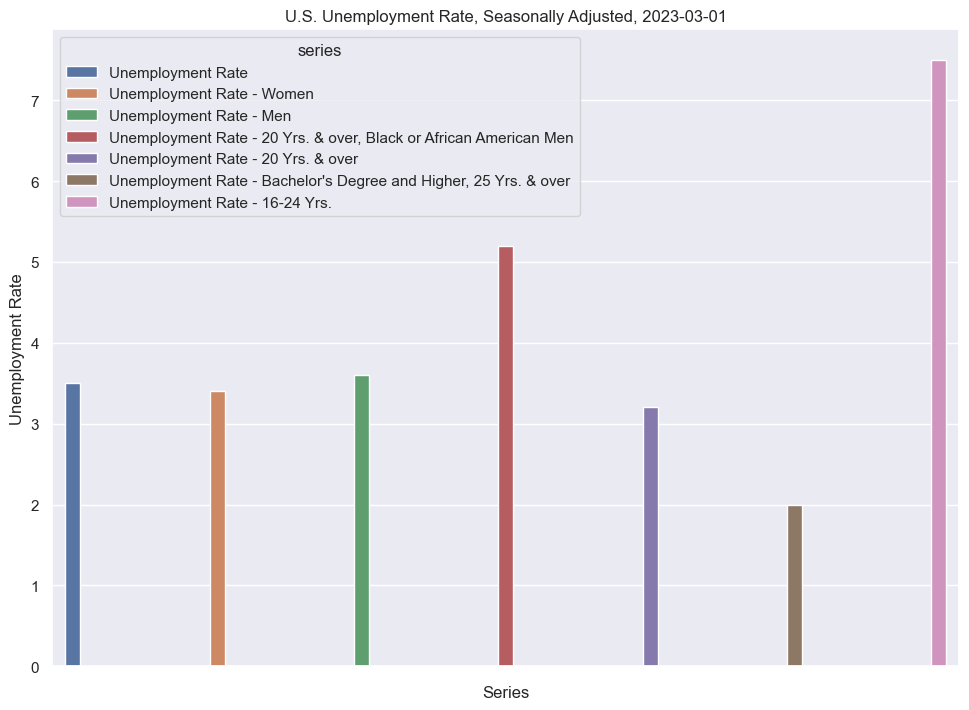

In [13]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})
ax = sns.barplot(
    data=long_df[long_df["date"] == max(long_df["date"])],
    x="series",
    y="value",
    hue="series",
)
plt.xticks(rotation=290)
ax.set(
    xlabel="Series",
    xticklabels=[],
    ylabel="Unemployment Rate",
    title=f"U.S. Unemployment Rate, Seasonally Adjusted, {max_date}",
)
sns.move_legend(ax, "best")

### Time series plot

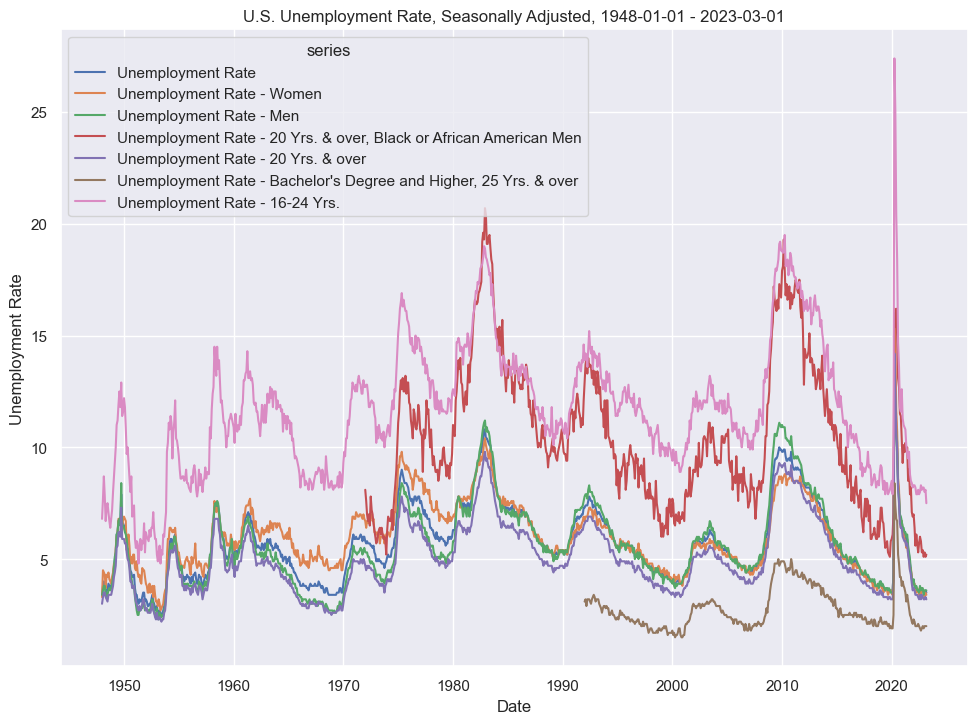

In [14]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})
ax = sns.lineplot(data=long_df, x="date", y="value", hue="series")
ax.set(
    xlabel="Date",
    ylabel="Unemployment Rate",
    title=f"U.S. Unemployment Rate, Seasonally Adjusted, {min_date} - {max_date}",
)
sns.move_legend(ax, "best")